<a href="https://colab.research.google.com/github/gwangjinjeong/Study_DeepLearning/blob/main/CNN/03_Horse_or_Human_classifier_with_Transfer_learning_and_dropout.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exercise Transfer learning and Dropout
Laurence Moroney가 무료로 배포한 Horse or Humans 데이터셋으로 Inception v3 모델을 Transfer learning하고
과적합을 방지하기 위해 Dropout을 적용해보도록 하자.

In [3]:
# Import all the necessary files!
import os
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model

# 1\. Horse or Human 데이터셋(training,validation) 다운로드


In [4]:
# Get the Horse or Human dataset
!wget --no-check-certificate https://storage.googleapis.com/laurencemoroney-blog.appspot.com/horse-or-human.zip -O /tmp/horse-or-human.zip

# Get the Horse or Human Validation dataset
!wget --no-check-certificate https://storage.googleapis.com/laurencemoroney-blog.appspot.com/validation-horse-or-human.zip -O /tmp/validation-horse-or-human.zip 
  
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import zipfile

local_zip = '//tmp/horse-or-human.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/training')
zip_ref.close()

local_zip = '//tmp/validation-horse-or-human.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/validation')
zip_ref.close()

--2022-03-30 15:46:35--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/horse-or-human.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.11.128, 74.125.31.128, 74.125.141.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.11.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 149574867 (143M) [application/zip]
Saving to: ‘/tmp/horse-or-human.zip’

/tmp/horse-or-human 100%[===================>] 142.65M   154MB/s    in 0.9s    

2022-03-30 15:46:36 (154 MB/s) - ‘/tmp/horse-or-human.zip’ saved [149574867/149574867]

--2022-03-30 15:46:36--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/validation-horse-or-human.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.26.128, 172.217.193.128, 172.217.204.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.26.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1148

# 2\. 환경변수 설정

In [5]:
train_horses_dir = '/tmp/training/horses'
train_humans_dir = '/tmp/training/humans'
validation_horses_dir = '/tmp/validation/horses'
validation_humans_dir = '/tmp/validation/humans'

train_horses_fnames = os.listdir(train_horses_dir)
train_humans_fnames = os.listdir(train_humans_dir)
validation_horses_fnames = os.listdir(validation_horses_dir)
validation_humans_fnames = os.listdir(validation_humans_dir)

print(len(train_horses_fnames))
print(len(train_humans_fnames))
print(len(validation_horses_fnames))
print(len(validation_humans_fnames))

500
527
128
128


# 3\. Tranfer learning


In [6]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2022-03-30 15:46:37--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.203.128, 172.253.123.128, 142.250.98.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.203.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M   169MB/s    in 0.5s    

2022-03-30 15:46:38 (169 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [7]:
# built-in 모델인 Inception_v3 사용을 위해 라이브러리 Import
from tensorflow.keras.applications.inception_v3 import InceptionV3

# 다운받은 사전에 훈련된 가중치로부터 초기 모델 인스턴스를 생성.
local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

pre_trained_model = InceptionV3(input_shape = (150, 150, 3),
                                include_top=False,
                                weights= None)

# import한 Inception_v3 모델에 가중치 업로드
pre_trained_model.load_weights(local_weights_file)

# 사전에 훈련된 모델의 모든 레이어를 Training 할 수 없도록 한다.
for layer in pre_trained_model.layers:
  layer.trainable = False
  
# Summary로 Inception v3 모델 overview
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 74, 74, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 74, 74, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                       

좀 더 많은 information을 담고 있는 'mixed7'이라는 상위 layer까지 사용



In [8]:
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 7, 7, 768)


## 모델 수정

In [10]:
from tensorflow.keras.optimizers import RMSprop

# mixed7의 출력 레이어를 1차원으로 Flatten
x = layers.Flatten()(last_output)
# 1,024개의 숨겨진 유닛과 ReLU를 activation function으로 완전히 연결된 레이어 추가
x = layers.Dense(1024, activation='relu')(x)
# 과적합을 방지하고자 Dropout을 적용
x = layers.Dropout(0.2)(x)
# Horse or Human 분류를 위해 최종 레이어에 Sigmoid activation function 가진 노드 추가
x = layers.Dense(1, activation='sigmoid')(x)

model = Model(pre_trained_model.input, x)

model.compile(optimizer = RMSprop(lr=0.0001), 
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 74, 74, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 74, 74, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


                                                                                                  
 conv2d_21 (Conv2D)             (None, 16, 16, 64)   76800       ['activation_20[0][0]']          
                                                                                                  
 conv2d_24 (Conv2D)             (None, 16, 16, 96)   82944       ['activation_23[0][0]']          
                                                                                                  
 conv2d_25 (Conv2D)             (None, 16, 16, 64)   18432       ['average_pooling2d_2[0][0]']    
                                                                                                  
 batch_normalization_19 (BatchN  (None, 16, 16, 64)  192         ['conv2d_19[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_nor

# 4\. 데이터 전처리


In [11]:
train_dir = '/tmp/training'
validation_dir = '/tmp/validation'

# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator( rescale = 1.0/255. )

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory('/tmp/training/',
                                                    target_size=(150, 150),  # All images will be resized to 300x300
                                                    batch_size=20,
                                                    # Since you use binary_crossentropy loss, you need binary labels
                                                    class_mode='binary')

# Flow validation images in batches of 20 using test_datagen generator
validation_generator =  test_datagen.flow_from_directory('/tmp/validation/',
                                                    target_size=(150, 150),  # All images will be resized to 300x300
                                                    batch_size=20,
                                                    # Since you use binary_crossentropy loss, you need binary labels
                                                    class_mode='binary')


# Expected Output:
# Found 1027 images belonging to 2 classes.
# Found 256 images belonging to 2 classes.

Found 1027 images belonging to 2 classes.
Found 256 images belonging to 2 classes.


# 5\. 모델 훈련


## Callback 함수 정의

In [12]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.999):
      print("\nReached 99.9% accuracy so cancelling training!")
      self.model.stop_training = True
callbacks = myCallback()

## fit

In [13]:
history = model.fit(
    train_generator,
    steps_per_epoch = 8,
    epochs = 100,
    verbose = 1,
    validation_data = validation_generator,
    validation_steps = 10,
    callbacks = [callbacks]
    )

Epoch 1/100
8/8 [==============================] - 15s 411ms/step - loss: 0.7194 - accuracy: 0.7688 - val_loss: 0.0460 - val_accuracy: 0.9800
Epoch 2/100
8/8 [==============================] - 2s 305ms/step - loss: 0.1076 - accuracy: 0.9500 - val_loss: 0.0318 - val_accuracy: 0.9900
Epoch 3/100
8/8 [==============================] - 2s 296ms/step - loss: 0.1109 - accuracy: 0.9796 - val_loss: 0.0145 - val_accuracy: 0.9950
Epoch 4/100
8/8 [==============================] - 2s 305ms/step - loss: 0.0541 - accuracy: 0.9750 - val_loss: 0.0156 - val_accuracy: 0.9900
Epoch 5/100
8/8 [==============================] - 2s 306ms/step - loss: 0.0644 - accuracy: 0.9750 - val_loss: 0.0460 - val_accuracy: 0.9750
Epoch 6/100
8/8 [==============================] - 2s 299ms/step - loss: 0.0311 - accuracy: 0.9937 - val_loss: 0.0376 - val_accuracy: 0.9850
Epoch 7/100
8/8 [==============================] - ETA: 0s - loss: 0.0101 - accuracy: 1.0000
Reached 99.9% accuracy so cancelling training!
8/8 [========

# 7\. 결과확인

## 시각화
Train할때 Data Augmentation을 아래와 같이 설정함
```
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)
```

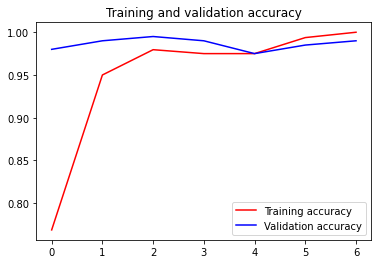

<Figure size 432x288 with 0 Axes>

In [14]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

## Trobleshooting
Train할때 Data Augmentation을 아래와 같이 설정했을때 fit 오류 발생
```
train_datagen = ImageDataGenerator(rescale=1/255,
                                   rotation_range=0.2,
                                   width_shift_range=[-0.2, 0.2],
                                   height_shift_range=[-0.2, 0.2],
                                   brightness_range=[-0.2, 0.2],
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   )
```